In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from default_constants import *
from ECE_mechanism.voltammogram_ECE_no_plot import CSV_ECE_ox
from plot_tools import extract_expe_like_CSV
from scipy.optimize import minimize

def plot_experimental_data(folder_name):
    directory = folder_name
    for filename in os.listdir(directory):
        if filename.endswith(".txt"): 
            path = os.path.join(directory, filename)
            df = pd.read_csv(path, delimiter = ';', decimal = ',')
            Potential = df['Potential applied (V)'].to_numpy()
            Intensity = df['WE(1).Current (A)'].to_numpy()
            plt.plot(Potential, Intensity, label = path)
            continue
        else:
            continue
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
    
def find_expe_csts_CSV(file_name):
    df = pd.read_csv(file_name, delimiter = ';', decimal = ',')
    Potential = df['Potential applied (V)'].to_numpy()
    Time      = df['Time (s)'].to_numpy()
    E_ox = max(Potential)
    E_red = min(Potential)
    E_start = Potential[0]
    Delta_E = Potential[1] - Potential[0]
    v = Delta_E/(Time[1] - Time[0])
    return(E_ox, E_red, Delta_E, v, E_start)

def find_I_E_t(file_name):
    df = pd.read_csv(file_name, delimiter = ';', decimal = ',')
    Pot_ap = df['Potential applied (V)'].to_numpy()
    I_expe = df['WE(1).Current (A)'].to_numpy()
    Time   = df['Time (s)'].to_numpy()
    return(I_expe, Pot_ap, Time)

def set_expe_cst(cst_all, cst_expe_new):
    cst_all_new = list(cst_all)
    cst_expe_new = list(cst_expe_new)
    cst_all_new[4] = list(cst_all_new[4])
    for i in range(len(cst_all_new[4])):
        cst_all_new[4][i] = cst_expe_new[i]
    cst_all_new[4] = tuple(cst_all_new[4])
    cst_all_new = tuple(cst_all_new)
    return(cst_all_new)   

def guess_potentials(E_0_1, E_0_2, cst_all):
    cst_all_new = list(cst_all)
    cst_all_new[2] = list(cst_all_new[2])
    cst_all_new[2][0] = E_0_1
    cst_all_new[2][9] = E_0_2
    cst_all_new[2] = tuple(cst_all_new[2])
    cst_all_new = tuple(cst_all_new)
    return(cst_all_new)  
    
def I_new(new_guess, *cst_expe_set):
    cst_expe_guess = cst_expe_set
    cst_expe_guess = list(cst_expe_guess)
    cst_expe_guess[2] = list(cst_expe_guess[2])
    cst_expe_guess[2][0] = new_guess[0]
    cst_expe_guess[2][9] = new_guess[1]
    cst_expe_guess[2][6] = new_guess[2]
    cst_expe_guess[2][7] = new_guess[3]
    cst_expe_guess[2][4] = new_guess[4]
    cst_expe_guess[2] = tuple(cst_expe_guess[2])
    cst_expe_guess = tuple(cst_expe_guess)
    I_simu_CSV = CSV_ECE_ox(cst_expe_guess)
    E_expe, I_simu_CSV_2 = extract_expe_like_CSV(cst_expe_guess, I_simu_CSV)
    return(I_simu_CSV_2)

def Error_I(I_new, *I_expe_CSV):
    Error = 0
    I_new = I_new/max(I_new)
    I_expe_CSV = I_expe_CSV/max(I_expe_CSV)
    for i in range(len(I_new)):
        Delta_I = I_new[i] - I_expe_CSV[i]
        Error += Delta_I**2
    print(Error)
    return(Error)

def fun_1(new_guess, *fixed_parms):
    cst_expe_set = fixed_parms[0]
    I_expe = fixed_parms[1]
    I = I_new(new_guess, *cst_expe_set)
    Err = Error_I(I, *I_expe)
    return(Err)
    

    # fitting with the error
def fit_experimental_data(file_name, guess):
    path = os.path.join('Examples_ECE', file_name)
    # adjust set up parameters
    cst_expe = find_experimental_potentials_CSV(path)
    cst_default = set_default_constants()
    cst_expe_set = set_expe_cst(cst_default, cst_expe)
    
    # define the function to minimize :
    cst_syst_guess = guess_potentials(guess[0], guess[1] , cst_expe_set)
    
    df = pd.read_csv(path, delimiter = ';', decimal = ',')
    I_expe_CSV = df['WE(1).Current (A)'].to_numpy()
    I_expe_CSV = I_expe_CSV/max(I_expe_CSV)
    E_expe_CSV = df['Potential applied (V)'].to_numpy()

    Best = minimize(fun_1, guess, 
                    args = (cst_expe_set, I_expe_CSV),  
                    method='SLSQP', 
                    bounds= ((0.4,0.8),(0.3,0.8), (0.001,10), (0.001,20), (0.00001,1))
                   )   
    #print(cst_expe_set[2])  
    return(Best)

    # curve fitting with the error
def fit_experimental_data_2(file_name, guess):
    path = os.path.join('Examples_ECE', file_name)
    # adjust set up parameters
    cst_expe = find_experimental_potentials_CSV(path)
    cst_default = set_default_constants()
    cst_expe_set = set_expe_cst(cst_default, cst_expe)
    
    # define the function to minimize :
    cst_syst_guess = guess_potentials(guess[0], guess[1] , cst_expe_set)
    
    df = pd.read_csv(path, delimiter = ';', decimal = ',')
    I_expe_CSV = df['WE(1).Current (A)'].to_numpy()
    I_expe_CSV = I_expe_CSV/max(I_expe_CSV)
    E_expe_CSV = df['Potential applied (V)'].to_numpy()

    Best = minimize(fun_1, (0.6, 0.5, 1, 1, 0.01), args = (cst_expe_set, I_expe_CSV), method='SLSQP')   
    #print(cst_expe_set[2])  
    return(Best)

In [2]:
path = os.path.join('Fit_Experimental_CSV', 'Examples_ECE')
print(path)

Fit_Experimental_CSV/Examples_ECE


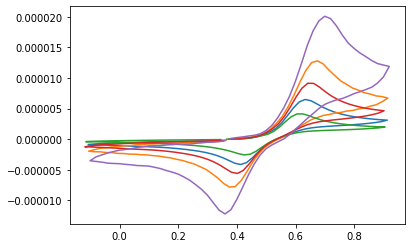

In [3]:
plot_experimental_data(path)

In [4]:
path_file = os.path.join(path, 'Che207 Ni(BinapSQ) 500mV s.txt')


In [5]:
def fit_expe(guess, path_file, cst_all):
    # set new values for cst_all extracted from the experimental data
    (E_ox, E_red, Delta_E, v, E_i) = find_expe_csts_CSV(path_file)
    cst_all["E_ox"]    = E_ox
    cst_all["E_red"]   = E_red
    cst_all["Delta_E"] = Delta_E
    if Delta_E > 0 :
        cst_all["Ox"]  = True
    else:
        cst_all["Ox"]  = False
    cst_all["v"]       = v
    cst_all["E_i"]     = E_i
    
    # extract I_expe from the datas
    (I_expe, Pot_ap, Time) = find_I_E_t(path_file)
    print(len(I_expe))
    
    # minimize the distance between I_expe and I_simulates
    Best = minimize(fun_ECE, guess, 
                    args = (cst_all, I_expe),  
                    method='L-BFGS-B', 
                    bounds= ((0.01,10000), (0.4,0.8), (0.3,0.8), (0.001,20), (0.00001,1)),
                    tol = 0.1)  
    return(Best)

# guess = (Lambda, E_0_1, E_0_2, k_p, k_m)
def fun_ECE(guess, *fixed_parms):
    # set the new constants for cst_all
    cst_new = fixed_parms[0]
    cst_new["Lambda"] = guess[0]
    cst_new["E_0_1"]  = guess[1]
    cst_new["E_0_2"]  = guess[2]
    cst_new["k_p"]    = guess[3]
    cst_new["k_m"]    = guess[4]
    
    # calculate the I correspomnding to theses new constants
    (param, E, C_init, M_new_constant, M_old, fun, fun_I) = initialise(cst_new)
    (I, Potential, Time) = calculate_I(param, E, C_init, M_new_constant, M_old, fun, fun_I)
    (Pot_expe, I) = extract_expe_like_CSV(param, I)
    
    # calculate the error between experimental and simulated intensity
    Err = Error_I(I, *fixed_parms[1])
    return(Err)


def Error_I(I_new, *I_expe_CSV):
    Error = 0
    I_new = I_new/max(I_new)
    I_expe_CSV = I_expe_CSV/max(I_expe_CSV)
    for i in range(len(I_new)):
        Delta_I = I_new[i] - I_expe_CSV[i]
        Error += Delta_I**2
    print(Error)
    return(Error)

In [6]:
from default_constants import default_constants
from main import *

#main programm to fit the data :
cst_all = default_constants()
# set mechanism type :
cst_all["mechanism"] = 'ECE'
# set molecule type :
cst_all["Reducible"] = False
# set concentration :
cst_all["C_a"] = 2E-3

path = os.path.join('Fit_Experimental_CSV', 'Examples_ECE')
path_file = os.path.join(path, 'Che207 Ni(BinapSQ) 500mV s.txt')
#guess = (100, 0.5, 0.5, 1.0, 1.0)
guess = (100, 5.55824144e-01, 4.41382398e-01, 9.71843960e-01, 1.00000000e+01)

Best = fit_expe(guess, path_file, cst_all)


102
358.5091789577226
358.50917895769487
358.50917774184467
358.5091773656504
358.5091809781585
358.5091785419629
153.68929788468515
153.68929788467247
153.68929983418195
153.6892978867959
153.68929878627947
153.68929788444606
191.48983601286008
191.4898360128539
191.48981789550672
191.48983601301262
191.48983832987196
191.48983601261023
162.60547901444951
162.6054790144408
162.60547169557205
162.60547902607934
162.6054809860109
162.60547901416444
159.42762601814061
159.4276260181246
159.42763436431636
159.42762603736418
159.42762741088927
159.42762601788306
153.54549623069224
153.54549623068115
153.54549562591802
153.54549623274636
153.5454971239461
153.54549623045176


In [7]:
Best

      fun: 153.54549623069224
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.10844667e-03, -6.04774215e+01,  2.05412221e-01,  8.93253855e+01,
       -2.40476083e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 2
   status: 0
  success: True
        x: array([1.00002773e+02, 7.97815033e-01, 8.00000000e-01, 1.00000000e-03,
       1.00000000e+00])

In [ ]:
#main programm to fit the data :
cst_all = default_constants()
# set mechanism type :
cst_all["mechanism"] = 'ECE'
# set molecule type :
cst_all["Reducible"] = False
# set concentration :
cst_all["C_a"] = 2E-3

# set new values for cst_all extracted from the experimental data
(E_ox, E_red, Delta_E, v, E_i) = find_expe_csts_CSV(path_file)
cst_all["E_ox"]    = E_ox
cst_all["E_red"]   = E_red
cst_all["Delta_E"] = Delta_E
if Delta_E > 0 :
    cst_all["Ox"]  = True
else:
    cst_all["Ox"]  = False
cst_all["v"]       = v
cst_all["E_i"]     = E_i


 # extract I_expe from the datas
(I_expe, Pot_ap, Time) = find_I_E_t(path_file)

guess = np.array([2, 0.5, 0.5, 1.0, 1.0])

def fun_ECE_cma(guess):
    # set the new constants for cst_all
    (param, E, C_init, M_new_constant, M_old, fun, fun_I) = initialise(cst_all)
    cst_new = param
    cst_new["Lambda"] = 10**(guess[0])
    cst_new["E_0_1"]  = guess[1]
    cst_new["E_0_2"]  = guess[2]
    cst_new["k_p"]    = 10**(guess[3])
    cst_new["k_m"]    = 10**(guess[4])
    
    # calculate the I correspomnding to theses new constants
    (param, E, C_init, M_new_constant, M_old, fun, fun_I) = initialise(cst_new)
    (I_simu, Potential, Time) = calculate_I(param, E, C_init, M_new_constant, M_old, fun, fun_I)
    (Pot_expe, I_new) = extract_expe_like_CSV(param, I_simu)

    # calculate the error between experimental and simulated intensity
    Err = Error_I(I_new, I_expe)
    return(Err)

def Error_I(I_new, I_expe_CSV):
    #print(len(I_new), len(I_expe_CSV))
    Error = 0
    I_new = I_new/max(I_new)
    I_expe_CSV = I_expe_CSV/max(I_expe_CSV)
    for i in range(len(I_new)):
        Delta_I = I_new[i] - I_expe_CSV[i]
        Error += Delta_I**2
    print(Error)
    return(Error)

import cma
from cma.evolution_strategy import CMAEvolutionStrategy
opts = cma.CMAOptions()
opts.set({'popsize': 200, 
          'maxiter' : 100000, 
          'maxfevals' : 10000, 
          'timeout' : "100000000.0 * 60**2", 
          'tolfun': 1e-4, 
          'tolfunhist': 1e-6})
es = CMAEvolutionStrategy(guess.astype(np.float16), 1, opts)
es.optimize(fun_ECE_cma, verb_disp=100, n_jobs = -1)

(100_w,200)-aCMA-ES (mu_w=52.6,w_1=4%) in dimension 5 (seed=876039, Fri Feb 19 16:41:44 2021)
4796.361859818732
24360935170.371628
352.7454063497824
961.0764970660622
326.29933128824285
1479.3072158297775
2456.143403591222
1250.921707635416
405.8300885849281
1495.9705300630742
2450.951769150903
194.58377705908427
161.74427613454512
3022.6096766045816
465.66153421544493
68.97669538316063
872.8791728297593
198.57084169937792
45.292697025753746
887.0298544496445
268.9348263911179
759.2319117631578
706.7018150467719
213.69069085983602
700.295581060567
851.067754105907
2221.3080232733487
810.1593439682553
915.6780622662471
8321.224891188376
51.90217108939182
15954.440443725272
120.76876536800366
669397.744434104
2340.789170777824
2457.344543902382
1104.894605779501
59.10075806344325
120.30092657433794
1958440.1513886682
97826.3776667019
16129.24017363191
774.7611712204694
1200.574591746936
12147.206320050975
52.05781369242957
2917.1954177488115
1565.3472590094282
10611.29284254178
3605.7943

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


nan
3794.721972886107


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


nan
1.9708149752420205e+22
599.0281955043308
902.1156489809642
2456.1433717420778
77.17409388738929
2483.3217580580986
4531.292956310033
878.5929803072173
52.12010714319737
76370.23087424062
343052506363491.9
1839.3209765296547
2496.6393771112816
171.16448884027616
2456.143238507612
1045.3182750583724
924.3999632912335
157.38362165828187
155.84975876441234
473.40681051681344
1.420861122018064e+16
39.649457508935626
71.85252731850495
806.0226247613181
5130.302858715931
124.0714077732891
672430.193339937
3585.3860880571683
108.03092729069893
702216922253758.6
8070.219841672941
74.54332695771622
25718.225903704904
1083.7164203308294
177.51280665590718
923.5447525547062
184918.42789001213
3462.158109924558
260679.79720258524
1.1355263493169058e+19
142.55270204820735
97.55241940394265
2455.5215534975428
2456.1433910932597
5174.027488136085
468.5539894461681
32.17588000798499
394.050079798745
2456.143391699209
5.109042586970188e+22
59.94462220148858
39.595173038714414
22601.718302803998
401.

/usr/local/anaconda3/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [97, 103]/[] are nan/None and will be set to the median value 916.5964748416593 (class=CMAEvolutionStrategy method=ask )
  ')')


50.77470726165935
7.367660939329661e+22
185.93152510591315
68.2645452974536
46.53138636775003
158.5202277227662
154.34833779240975
160.17414005094747
65.8311653932569
120.68567616942322


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


nan
2456.143391696384
2456.1435066994263
430.00285414829955
58.04084967662592
1559.6626378765714
51.61300537274176
1066.6938068515753
36.9042168868599
17852.21734420684
248.54378451996584
17.001956885985148
1043.6352039329613
68.06570257506465
509.4866309439354
7.902352729863407e+21
788.3506668468581
107.50786422603304
51.85444361360313
51.52261745667661
51.590554590485084
4037.51908569118
13173234.644374214
2456.129850294524
19.535631956210462
62.44364222417671
160.26237171900135
364.7523676847795
nan
86713.16751636539
52.34644532631659
4409.328914426115
15351.234486431602
935.739192201771
36.246928789446066
2181.147213454051
18.333542243736126
51.83971819661593
388.01753419558287
117.69973742789125
17.95694953439381
6440.882223528594
52.653789937610625
57.97093017569947
190.29823069972358
855.0193064396151


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


nan
1.6422974289759652e+23
86.91912117155105
663.4330154007888
27.683070331643528
2456.143391696384
6.136722900415738e+17
7.387220508319815e+22
1580.6136932331763
177.13638378948843
5544.25416336073
190.56563412662217
51.636311905313285
37.16005350793598
1235.52979626565
59.94390142189606
31.642564098237724
40.637615878805924
57.95438954382847
187.46043689536538
2.90673244982455e+22
125.99002986037638
52.41339837756607
100.68750393978247
32.994535866525446
53.85402831073896
102.32911670648909


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


nan
16.569795960851888
177.7517329955762
55.466142650013175
1.799500244552998e+18
9413.874859981926
53.52029145680364
77.88803151252424
4412.483971372537
51.59596370653526
38.38639866966312
2456.1433916972514
45.387029857223276
514.5766578365754
56.48533605575276
288012.9641188772
33.50633554970791
53.08936407946077
2456.1432514320895
nan
122.55647441560176
986.7754537079717
29.886823640032475
271.16315450648665
2.21455507901615e+23
9131.898282995811
2456.143391483669
63.34955194654204
52.12090664738056
52.587031697864724
944.9420752814556
51.63397765834408
1327.865735202309
1323.2431345131577
438.16847452509023
30.799069832729586
1.7674194660817334e+23
42.69067420219078
15021.723338830132
488.06822577154315
189.8930385800164


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


nan
791.8913272919672
3693105388615630.5
41.156080569409255
52.53561213126391
2456.212683748233
52.35823308343982
nan
271032.3429882156
2454.8754132794215
552.5543734229842
599.6253031346369
1657.8906135241136
465.530386108765
18.958387163650894
115.74227546512158
2473.10874770643
1073.90349440427
60.523834809681304
193.28211934100804


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


nan
51.92435284577703
9.045353282132232e+18
50.43079771446057
141.66578625554655
479.3371843517288
592.704001502718
4262163.363607628
123.50291999588589
436.0337847754191
51.60384056892842
1.1753997648990413e+22
76.32546349144852
16.32183337163745
2450.1524017489396
1.6258916103631618e+20
1049.834077148015
746.4810106183877
48.23923018821258
9.972467970111887e+18
1041.48601705798
53.58679787434362
53.386590271562966
305903261.8913402
29.26850422664202
524173.3943958696
805.7172606427524
8072170.8833414
2456.143391366261
148.3356731706301
2456.143386521105
3.1181629260676365e+21
28.527084146630038
252.65826080767295
54.79257020775509
67.88923258941952
4.9812177034941995e+20
44.62389858988702
51.59985732683249
17.722386486849274
2456.1433916963847
42.6107803589343
51.80955345475636
2456.143391696236
1609192.9552591795
54.90369715383832
159.84297639276133
51.981708828452405
52.40607022637729
3317.452811232164
1191.0388464095008
57.93433647583455
77.35377162306456
29.48850821357965
53.2579

/usr/local/anaconda3/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [8, 39, 56, 84, 102, 124, 131, 144]/[] are nan/None and will be set to the median value 181.84162905074467 (class=CMAEvolutionStrategy method=ask iteration=1)
  ')')


58.90961096469182
1605.1914242031282
1939616257058720.0
51.63209234728807
997.4576657749764
86.79541190928514
76.45156520403056
45.12334247047028
18.240139776614328
638545.666618439
nan
967.3585687168483
61.28905129729945
51.590811090370295
33383.093499285875
56.79073489295707
nan
51.598421446230944
27.45709644248017
270.167710201889
52.866358556222124
2101.06950143199
51.9555623558783
54.16198595586205
16.328462089904075
21.256314930547102
1164.3423183777625
33.429058891709516
187.56567131615907
nan
992.5478656038673
659.8591645408515
2.0567815195221673e+23
167.39922830050872
18.135099267174002
nan
23833551.9268305
51.54447260298456
16.86996460020181
51.5915130844584
22487697.47749734
49.91657539080766
52.74415267537974
726.5023058096742
nan
454138.06291709736
51.59094435079632
926.0079146799551
51.59654662809888
17.59322662030511
1.6431130617218554e+23
181.60688890097177


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide


nan
nan


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


nan
32.38896677056547
nan
43.48014957345685
95.33475043167925
2455.9796938911827
51.59091998077882
199.28972106138545
21.547040641017492
21618288885.580925
51.83514502213597
2487.796439578962
56.90898743935935
52.74766968724791
28.36056688126078
57.62803566534805
52.16944540574647
17.488769504158338
29.876721371250056
51.59569588524493
51.59025020763234
nan
52.00453675988414
806.365153125002
258.66182615124796
nan
13427.9149570472
34.54962299135489
51.62805828495795
34.184240037520176
119.93368648167215
nan
305.20092273498335
nan
21.865547821636277
52.1233703553176
1474.0774797895247
51.60715186229559
51.62795541245454
51.590529674755416
nan
nan
53.298567088453964
16430.96041155078
973.62945038833
46444061432297.86
49.181983980906956
32.49293136209833
54.29776258847626
51.618961170632545
51.3318242749212
37247.39243355429
68.57974483446685
57.4574326117073
nan
51.77583203336164
51.84247487944572
3238.309053804346
2456.143410636315
51.600355464016225
29.976458553455505
6.755176910299091

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide


nan
51.83236945245137
51.61726402428866
51.59075356752622
227.1508126371767
2860.1640462677315
55.1915444404706
166.5091047368343
51.80388785032282
82.63551665054368
175.09534799436784
nan
54.4630238973504
73.55079776090162
50.74762474858306
53.12872565634242
51.872891025990434
45.31614864940596
32.494930362154875
21.187358802894085
3095.378580525947
34.09318631012876
11217.292298287772
2456.146151584512
33.26425677867084
17.79744126387351
211.046666270505
14985.56986492817
nan
394.90913972890655
nan
51.565894368237124
51.590654835396414
1.566873388339389e+23
43.01908484632251
51.74634606158172
33.53158153613102
2455.4169120657216
1166129.2129176336
2456.1433916920705
54.621801803034785
61.749956831205154
51.46522351792957
2456.1433916951723
    3    600 1.632846208990408e+01 2.3e+00 2.00e+00  8e-01  2e+00 241:19.2


/usr/local/anaconda3/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [9, 16, 28, 34, 43, 51, 53, 54, 57, 77, 79, 86, 87, 94, 95, 108, 126, 135, 138, 150, 153, 157, 167, 184, 187]/[] are nan/None and will be set to the median value 54.621801803034785 (class=CMAEvolutionStrategy method=ask iteration=2)
  ')')


51.59102085347097
51.79197317377383
34.59911493228461
18.25505845825268
51.665872756268534
3754.886847573535
51.590526803482845
51.604039280872904
20.022220587045513
271.8895971497339
51.59039904998785
24.12610667687804
20.564802736302553
52.70677217879205
51.59053364980223
2455.9686854301067
15.537874675825673
11581666664.20337
51.06348191922762
51.590552494761404
51.588099700213455
82.50626785500631
51.829377430447586
52.47003253220728
18.968198057377624
51.59695703983089
51.59073805669375
921.3648288885415
20.219173695397025
nan
50.83179716221333
16.28455383890591
nan
91.01533591668773
51.05301046136313
29.249606504230872
51.82427117999787
16.395654850895998
43.390914148072234
51.553906120263214
51.594546155115054
51.64933368918065
51.594543889159034
51.590767317155034
51.745314717701014
15584.931873307001
207.0960876811646
1299.0788109527907
1711.6370287705238
51.63775404395153
51.63930642488874
16.453880564059414
51.64095796294888
51.60997439585253
52.261873782270094
344.766596275

/usr/local/anaconda3/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [30, 34, 75, 95]/[] are nan/None and will be set to the median value 51.59575159747297 (class=CMAEvolutionStrategy method=ask iteration=3)
  ')')


51.84318662724064
17.85103197334678
45.96872794076329
51.590479557186164
51.66513674828147
80.86754584024548
51.58623807989163
52.53369271988812
1865346.9682148786
15.552787705196934
64.7304524939641
51.59928475564012
51.60174538537095
18.694420763367624
21.252072659908368
55.60522156460397
23.04000202115549
51.51924827539533
51.59182790345216
51.59518642725236
17.88191982943926
12975781.43660933
61.42523614748697
177.47971080922153
34.029127565094754
51.601555961573744
21.480280907017114
51.65827462377843
53.70714711815731
51.6101497816622
51.626294029915414
599283351.4671375
23.618959366855314
51.63850366888642
26.02912680246377
165.23287770326547
53.84421533318228
56.231900185356565
51.592667520131634
51.71133348232588
30.297741589952523
51.38988984858917
99.17752527076942
234.14175658956586
27.464738336491454
51.68841180531089
51.605593860171176
63.861177044395255
76.95591033081345
65.4574566149757
18.241489877586854
51.4949167265318
51.999331732863546
51.591378125155444
54.5947648

In [16]:
path_file

'Fit_Experimental_CSV/Examples_ECE/Che207 Ni(BinapSQ) 500mV s.txt'